In [1]:
import numpy as np
import dask.array as da
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import glob

In [57]:
def load_data(slice_folder, label_folder):

    # Use glob to get a list of all .npy files in the folders
    slice_files = sorted(glob.glob(os.path.join(slice_folder, '*.npy')))
    label_files = sorted(glob.glob(os.path.join(label_folder, '*.npy')))

    # Initialize lists to store slices and labels
    slices = []
    labels = []

    print(len(slice_files))
    print(len(label_files))
    # Load the .npy files as Dask arrays
    for i in range(len(slice_files)):
        print(f"Loading slice file: {slice_files[i]}")
        slices.append(da.from_array(np.load(slice_files[i])))

        print(f"Loading label file: {label_files[i]}")
        labels.append(np.load(label_files[i], allow_pickle=True))
        
    # Convert lists to Dask arrays
    slices = da.stack(slices)
    labels = da.stack(labels)

    return slices, labels

slice_folder = 'Slice'
label_folder = 'Label'

slices, labels = load_data(slice_folder, label_folder)
print(f"Loaded {len(slices)} slices and {len(labels)} labels.")
print(f"Example slice shape: {slices[0].shape if len(slices) > 0 else 'N/A'}")
print(f"Example label: {labels[0] if len(labels) > 0 else 'N/A'}")

8344
8344
Loading slice file: Slice\CQ500-CT-100_Slice0.npy
Loading label file: Label\CQ500-CT-100_Label0.npy
Loading slice file: Slice\CQ500-CT-100_Slice1.npy
Loading label file: Label\CQ500-CT-100_Label1.npy
Loading slice file: Slice\CQ500-CT-100_Slice10.npy
Loading label file: Label\CQ500-CT-100_Label10.npy
Loading slice file: Slice\CQ500-CT-100_Slice11.npy
Loading label file: Label\CQ500-CT-100_Label11.npy
Loading slice file: Slice\CQ500-CT-100_Slice12.npy
Loading label file: Label\CQ500-CT-100_Label12.npy
Loading slice file: Slice\CQ500-CT-100_Slice13.npy
Loading label file: Label\CQ500-CT-100_Label13.npy
Loading slice file: Slice\CQ500-CT-100_Slice14.npy
Loading label file: Label\CQ500-CT-100_Label14.npy
Loading slice file: Slice\CQ500-CT-100_Slice15.npy
Loading label file: Label\CQ500-CT-100_Label15.npy
Loading slice file: Slice\CQ500-CT-100_Slice16.npy
Loading label file: Label\CQ500-CT-100_Label16.npy
Loading slice file: Slice\CQ500-CT-100_Slice17.npy
Loading label file: Label

In [ ]:
if slices[-1] == 1:  # Assuming your slices are grayscale
    slices = np.repeat(slices, 3, axis=-1)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(slices, labels, test_size=0.20, random_state=42)

In [59]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])

In [60]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling to reduce dimensionality
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification output layer

In [61]:
model = Model(inputs=base_model.input, outputs=predictions)


In [62]:
print(model)

<Functional name=functional_2, built=True>


In [63]:
for layer in base_model.layers:
    layer.trainable = False

In [64]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
x_train.compute()
print(f"x_train shape: {x_train.shape}")

x_test.compute()
print(f"x_test shape: {x_test.shape}")

x_train shape: (6675, 224, 244, 3)
x_test shape: (1669, 224, 244, 3)


In [69]:
print(x_train[2])

dask.array<getitem, shape=(224, 244, 3), dtype=float64, chunksize=(224, 244, 3), chunktype=numpy.ndarray>


In [ ]:

"""for i in range(x_train):
    i.compute()
print(f"x_train shape: {x_train.shape}")

for i in range(x_test):
    i.compute()
print(f"x_test shape: {x_test.shape}")"""

In [70]:
x_train = np.array(x_train).astype(np.float32)
print(x_train)

x_test = np.array(x_test).astype(np.float32)
print(x_test)

[[[[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  [[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  [[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  ...

  [[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  [[  0.        90.54693    0.      ]
   [  0

In [71]:
y_train.compute()
print(f"y_train shape: {y_train}")

y_test.compute()
print(f"y_test shape: {y_test}")

y_train shape: dask.array<getitem, shape=(6675,), dtype=object, chunksize=(1,), chunktype=numpy.ndarray>
y_test shape: dask.array<getitem, shape=(1669,), dtype=object, chunksize=(1,), chunktype=numpy.ndarray>


In [72]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [73]:
print(x_train)
print(x_test)
print(y_train)
print(y_test)

[[[[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  [[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  [[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  ...

  [[  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   ...
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]
   [  0.        90.54693    0.      ]]

  [[  0.        90.54693    0.      ]
   [  0

In [74]:
print(x_train.shape, x_train.dtype)
print(x_test.shape,  x_test.dtype)
print(y_train.shape, y_train.dtype)
print(y_test.shape,  y_test.dtype)

(6675, 224, 244, 3) float32
(1669, 224, 244, 3) float32
(6675,) object
(1669,) object


In [75]:
y_bool_train = []
for label in y_train:
    y_bool_train.append(label['label'])

print(y_bool_train)


y_bool_test = []
for label in y_test:
    y_bool_test.append(label['label'])

print(y_bool_test)

[True, True, False, True, False, True, True, False, False, True, True, True, True, True, False, True, True, False, False, False, True, True, False, False, False, True, True, False, False, False, False, False, True, True, True, False, False, True, True, True, False, False, False, False, True, True, False, False, True, False, True, False, True, False, False, False, False, True, False, True, False, True, False, False, True, True, True, True, False, False, False, False, False, True, False, False, True, False, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, True, True, False, True, True, False, False, False, False, True, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False, False, True, True, True, False, False, False, False, True, True, False, True, True, False, True, False, F

In [76]:
int_labels_train = []
for int_labels in y_bool_train:
    if int_labels == True:
        int_labels_train.append(1)
    else:
        int_labels_train.append(0)
print(int_labels_train)

int_labels_test = []
for int_labels in y_bool_test:
    if int_labels == True:
        int_labels_test.append(1)
    else:
        int_labels_test.append(0)
print(int_labels_test)

int_labels_train = np.array(int_labels_train).astype(np.float32)
int_labels_test = np.array(int_labels_test).astype(np.float32)

print(int_labels_train.shape, int_labels_train.dtype)
print(int_labels_test.shape, int_labels_test.dtype)

[1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 

In [77]:
history = model.fit(x_train, int_labels_train, validation_data=(x_test, int_labels_test), epochs=25, batch_size=32)

Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.5515 - loss: 1.0635 - val_accuracy: 0.5698 - val_loss: 0.7022
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.5733 - loss: 0.7097 - val_accuracy: 0.5806 - val_loss: 0.7063
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.5925 - loss: 0.6843 - val_accuracy: 0.5806 - val_loss: 0.6876
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.6151 - loss: 0.6704 - val_accuracy: 0.5806 - val_loss: 0.6827
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.6229 - loss: 0.6641 - val_accuracy: 0.5806 - val_loss: 0.6822
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.6088 - loss: 0.6715 - val_accuracy: 0.5806 - val_loss: 0.6828
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.6041 - loss: 0.6727 - val_accuracy: 0.5806 - val_loss: 0.6864
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.6177 - loss: 0.6659 - val_accu

In [78]:
test_loss, test_acc = model.evaluate(x_test, int_labels_test)
print(f"Test Accuracy: {test_acc}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5748 - loss: 0.6884
Test Accuracy: 0.5805871486663818


In [79]:
y_pred = (model.predict(x_test) > 0.5).astype(int)
y_true = y_test  # Ground truth

53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step


In [80]:
print(y_pred)
print(y_true)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
[{'scan_id': 36, 'label': False} {'scan_id': 26, 'label': False}
 {'scan_id': 23, 'label': False} ... {'scan_id': 85, 'label': False}
 {'scan_id': 175, 'label': False} {'scan_id': 27, 'label': False}]


In [ ]:
precision = precision_score(y_true, y_pred)
recaall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

In [82]:
import matplotlib.pyplot as plt

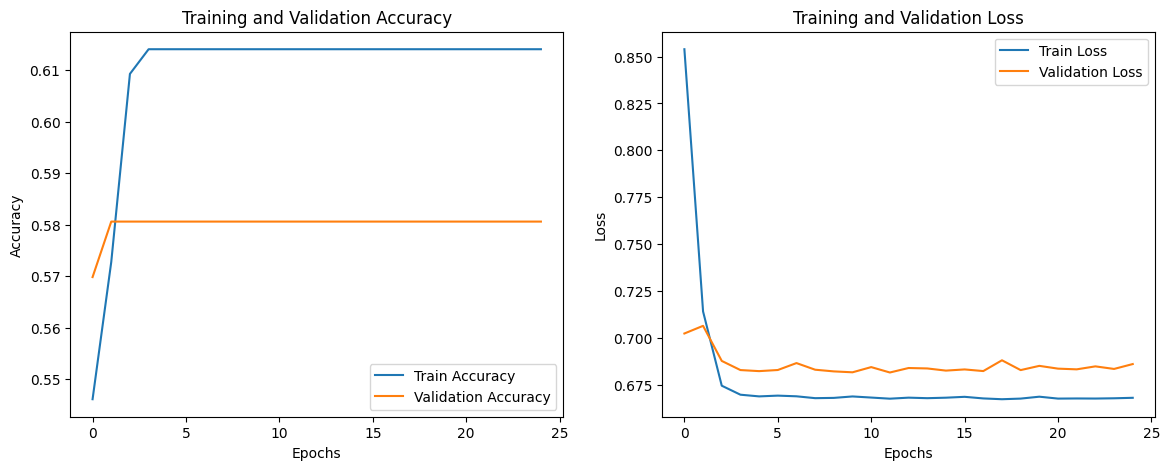

In [83]:
# Plot Training & Validation Accuracy and Loss
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_history(history)


In [ ]:
# Precision, Recall, F1 Score, and Accuracy
def plot_metrics(precision, recall, f1, accuracy):
    metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
    scores = [precision, recall, f1, accuracy]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Precision, Recall, F1 Score, and Accuracy')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.show()

# Call the function to plot precision, recall, f1, and accuracy
plot_metrics(precision, recall, f1, accuracy)


In [ ]:
# IoU Calculation
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

iou = calculate_iou(y_true, y_pred)

def plot_iou(iou):
    plt.figure(figsize=(6, 4))
    plt.bar(['IoU'], [iou], color='#9467bd')
    plt.title('Intersection over Union (IoU)')
    plt.ylim(0, 1)
    plt.ylabel('IoU Score')
    plt.show()

plot_iou(iou)


In [ ]:
def plot_all_metrics(history, precision, recall, f1, accuracy, iou):
    # Accuracy and Loss
    plot_history(history)
    
    # Precision, Recall, F1 Score, and Accuracy
    plot_metrics(precision, recall, f1, accuracy)

    # Plot IoU
    plot_iou(iou)

# Call the function to plot everything after training
plot_all_metrics(history, precision, recall, f1, accuracy, iou)
